In [2]:
import pandas as pd

In [40]:
from scipy import stats
import numpy as np

## Remove outliers using Z score

def drop_coordinates_outliers(data):
    data = data.copy()
    print('Data shape before removing outliers: ', data.shape)
    data = data[((data.lat > 0.0)&(data.lon> 0.0))]
    z_lat, z_lon = np.abs(stats.zscore(data.lat)), np.abs(stats.zscore(data.lon))
    
    threshold = 2.5
    lat_outliers = np.where(z_lat > threshold)
    lon_outliers = np.where(z_lon > threshold)
    
    data_no_outliers = data.loc[~data.index.isin(np.concatenate((lat_outliers[0], lon_outliers[0])))].reset_index(drop=True)
    print('Data shape after removing outliers: ', data.shape)
    return data_no_outliers

### First of all we need to know the bounds of area which we will use for training

In [41]:
valid = pd.read_csv('./valid.csv')
valid = valid.drop_duplicates()

valid['hour'] = pd.to_datetime(valid['hour'], unit='s')

In [42]:
valid_no_outliers = drop_coordinates_outliers(data=valid.copy())
valid.head(5)

Data shape before removing outliers:  (709, 6)
Data shape after removing outliers:  (686, 6)


,hour,lat,lon,point,sum,error
0,2020-02-23 09:00:00,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,2020-02-20 19:00:00,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,2020-02-09 15:00:00,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,2020-02-17 17:00:00,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,2020-02-27 05:00:00,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [43]:
LAT_MIN_BOUND, LAT_MAX_BOUND = valid_no_outliers.lat.min(), valid_no_outliers.lat.max()
LON_MIN_BOUND, LON_MAX_BOUND = valid_no_outliers.lon.min(), valid_no_outliers.lon.max()

In [44]:
print('Rectangle of interest: ', LAT_MIN_BOUND, LAT_MAX_BOUND, LON_MIN_BOUND, LON_MAX_BOUND)

Rectangle of interest:  59.82893394227072 60.03933228251395 30.14296935863054 30.53598229543283


## Read and process train data according to rectangle of interest

In [8]:
train = pd.read_csv('./train_data.zip')
print('Train before dropping duplicates: ', train.shape)

train = train.drop_duplicates()
print('Train after dropping duplicates: ', train.shape)

# Filter all locations with less than 5 events in it 
train = train.groupby("point").filter(lambda x: len(x) > 5)
print('Train after filtering out rare cubes: ', train.shape)

# Convert unix timestamp to normal time
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train = train.reset_index(drop=True)

Train before dropping duplicates:  (8526526, 12)
Train after dropping duplicates:  (8456776, 12)
Train after filtering out rare cubes:  (8454375, 12)


In [9]:
# Drop all cubes that are not included in rectangle of interest
train_processed = train[((train.lat <= LAT_MAX_BOUND)&(train.lat >= LAT_MIN_BOUND)&(train.lon <= LON_MAX_BOUND)&(train.lon >= LON_MIN_BOUND))]
print('Train after removing cubes which are out of rectangle of interest: ', train_processed.shape)

Train after removing cubes which are out of rectangle of interest:  (8295361, 12)


In [45]:
train_processed.head(5)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427
3,2019-08-12 00:00:00,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,202,427
4,2019-08-12 00:00:00,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...,213,454


In [46]:
min_lat, max_lat = train_processed.lat.min(), train_processed.lat.max()
min_lon, max_lon = train_processed.lon.min(), train_processed.lon.max()

In [12]:
print('Rectangle of interest in train data: ', min_lat, max_lat, min_lon, max_lon)

Rectangle of interest in train data:  59.82893394227072 60.03933228251395 30.14521514684084 30.53598229543283


## Move coordinates to "image" grid

In [13]:
def lat_to_grid(inp):
    return round((LAT_MAX_BOUND - inp) / 0.0005)

def lon_to_grid(inp):
    return round((LON_MAX_BOUND - inp) / 0.0005)

In [14]:
train_processed.loc[:, 'lat_gird'] = train_processed['lat'].apply(lambda x: lat_to_grid(x))
train_processed.loc[:, 'lon_gird'] = train_processed['lon'].apply(lambda x: lon_to_grid(x))

/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [18]:
train_processed.head(3)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427


In [19]:
train_processed_x = train_processed.groupby(by=['timestamp', 'point']).size().reset_index(name='num_of_posts')
train_processed_x.sort_values('num_of_posts')

,timestamp,point,num_of_posts
0,2019-01-01 00:00:00,0101000020E610000002BF48199F3F3E4010C569574E02...,1
2094695,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4041CA35D0FCFC...,1
2094696,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4053FFA7E47BF3...,1
2094698,2019-09-06 13:00:00,0101000020E6100000B8FFF2B7CB443E408991431816F7...,1
2094699,2019-09-06 13:00:00,0101000020E6100000BE54A7FF7E423E400D42027446FD...,1
...,...,...,...
1646443,2019-07-21 20:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,377
2562728,2019-10-19 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,393
2846146,2019-11-16 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,401
1646846,2019-07-21 21:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,411


### Add lat and lon to grouped dataframe

In [20]:
tp = train_processed.drop_duplicates(['lon', 'lat', 'point'])

In [21]:
train_processed_x = pd.merge(left=tp[['lon', 'lat', 'point']], right=train_processed_x, on='point', how='right')

In [47]:
train_processed_x.head()

,lon,lat,point,timestamp,num_of_posts
0,30.248521,60.018016,0101000020E610000002BF48199F3F3E4010C569574E02...,2019-01-01,1
1,30.248521,59.850372,0101000020E610000002BF48199F3F3E40586790FFD8EC...,2019-01-01,1
2,30.239538,59.965226,0101000020E61000000614FD60523D3E400086058A8CFB...,2019-01-01,1
3,30.239538,59.858267,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,2019-01-01,2
4,30.239538,60.037089,0101000020E61000000614FD60523D3E40D800D455BF04...,2019-01-01,1


In [21]:
year_month_day_format = '%Y-%m-%d'
train_processed_x['Ymd'] = train_processed_x['timestamp'].apply(lambda x: x.strftime(year_month_day_format))

### Make an image at certain timestamp 

In [22]:
train_processed_x[(train_processed_x.timestamp=='2020-01-31 13:00:00')]

,lon,lat,point,timestamp,num_of_posts,Ymd
3565849,30.248521,60.009036,0101000020E610000002BF48199F3F3E4042A0141A2801...,2020-01-31 13:00:00,1,2020-01-31
3565850,30.248521,59.851500,0101000020E610000002BF48199F3F3E40892F7FF5FDEC...,2020-01-31 13:00:00,1,2020-01-31
3565851,30.248521,60.022505,0101000020E610000002BF48199F3F3E408F79686EE102...,2020-01-31 13:00:00,1,2020-01-31
3565852,30.381023,59.924735,0101000020E610000003D9A4B78A613E4033438EB75DF6...,2020-01-31 13:00:00,1,2020-01-31
3565853,30.513524,59.908975,0101000020E610000003F3005676833E40DAABFA4A59F4...,2020-01-31 13:00:00,1,2020-01-31
...,...,...,...,...,...,...
3566388,30.257505,59.896587,0101000020E6100000FE6994D1EB413E401F04E95BC3F2...,2020-01-31 13:00:00,1,2020-01-31
3566389,30.257505,60.010159,0101000020E6100000FE6994D1EB413E40A3B0DDE24C01...,2020-01-31 13:00:00,15,2020-01-31
3566390,30.390006,59.884194,0101000020E6100000FF83F06FD7633E409E5212462DF1...,2020-01-31 13:00:00,1,2020-01-31
3566391,30.390006,60.024749,0101000020E6100000FF83F06FD7633E40A0E9FCF72A03...,2020-01-31 13:00:00,1,2020-01-31


In [23]:
def generate_image(spec_timestamp, input_data):
    data = np.zeros((round((LON_MAX_BOUND-LON_MIN_BOUND) / 0.0005)+1, round((LAT_MAX_BOUND-LAT_MIN_BOUND) / 0.0005)+1), dtype=np.uint8)
    for _, row in input_data[(input_data.timestamp==spec_timestamp)][['lat', 'lon', 'num_of_posts']].iterrows():
        lon, lat, n_posts = row.lon, row.lat, int(row.num_of_posts)
        try:
            data[round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005)] = n_posts * 100 # Multiplied by 100 in order to make visualization brighter
        except Exception as e:
            print(e)
            print(lon, lat)
            print(round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005))
    return data

In [24]:
data = generate_image('2020-01-31 13:00:00', input_data=train_processed_x)
data.shape

(787, 422)

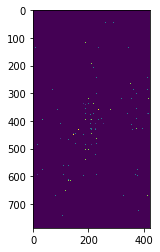

In [25]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
plt.show()

In [26]:
data.shape

(787, 422)

In [27]:
train_processed_x.timestamp.min()

Timestamp('2019-01-01 00:00:00')

In [25]:
# For image normalization
pixels_norm = train_processed_x.num_of_posts.max() # [(train_processed_x.timestamp=='2020-01-31 13:00:00')].num_of_posts.max()
pixels_norm 

540

In [50]:
from tqdm import tqdm
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date) / np.timedelta64(1, 'h'))):
        yield start_date + timedelta(hours=n)

def generate_image_set(data, start_date=pd.Timestamp('2020-01-25T23')):
    train_3d_images = []
    ground_truth = []
    end_date = data.timestamp.max()
    
    end_date = end_date-timedelta(hours=5+1)
    
    for single_date in tqdm(daterange(start_date, end_date), total=len(list(daterange(start_date, end_date)))):
        three_d_image = []
        inner_end_date = single_date + timedelta(hours=5)
        ground_truth.append(generate_image(spec_timestamp=single_date + timedelta(hours=5), input_data=data))
        for inner_single_data in daterange(single_date, inner_end_date):
            three_d_image.append(generate_image(spec_timestamp=inner_single_data, input_data=data))
        train_3d_images.append(three_d_image)
    return train_3d_images, ground_truth, single_date

In [52]:
print(len(train_processed_x) // 4)
print()
for i in range(892773, len(train_processed_x), 892773):
    print(i)

892773

892773
1785546
2678319
3571092


In [48]:
train_processed_x.iloc[892773]

lon                                                     30.360811
lat                                                     59.949486
point           0101000020E61000004D98FA185E5C3E408F0FCDBE88F9...
timestamp                                     2019-04-23 18:00:00
num_of_posts                                                    2
Name: 892773, dtype: object

In [49]:
train_processed_x.iloc[892772]

lon                                                     30.360811
lat                                                     59.930362
point           0101000020E61000004D98FA185E5C3E408991431816F7...
timestamp                                     2019-04-23 18:00:00
num_of_posts                                                    1
Name: 892772, dtype: object

In [53]:

train_X_0, train_y_0, last_date = generate_image_set(data=train_processed_x.iloc[:892773], start_date=pd.Timestamp('2019-01-01T00'))
np.save('./train_X_0.npy', train_X_0)
np.save('./train_y_0.npy', train_y_0)
print(last_date)

100%|██████████| 2700/2700 [06:22<00:00,  7.06it/s]


2019-04-23 11:00:00


In [55]:
train_X_1, train_y_1, last_date = generate_image_set(data=train_processed_x.iloc[892773:1785546], start_date=pd.Timestamp('2019-04-23T11'))
np.save('./train_X_1.npy', train_X_1)
np.save('./train_y_1.npy', train_y_1)
print(last_date)

100%|██████████| 2554/2554 [06:17<00:00,  6.76it/s]


2019-08-07 20:00:00


In [56]:
train_X_2, train_y_2, last_date = generate_image_set(data=train_processed_x.iloc[1785546:2678319], start_date=pd.Timestamp('2019-08-07T03'))
np.save('./train_X_2.npy', train_X_2)
np.save('./train_y_2.npy', train_y_2)
print(last_date)

 68%|██████▊   | 1356/2002 [04:12<02:00,  5.38it/s]


KeyboardInterrupt: 

In [37]:
train_X_3, train_y_3 = generate_image_set(data=train_processed_x.iloc[2678319:], start_date=pd.Timestamp('2019-10-30T19'))
np.save('./train_X_3.npy', train_X_3)
np.save('./train_y_3.npy', train_y_3)

100%|██████████| 2230/2230 [06:06<00:00,  6.09it/s]


In [32]:
train_X_0, train_X_1, train_X_2, train_X_3 = np.load('./train_X_0.npy'), np.load('./train_X_1.npy'), np.load('./train_X_2.npy'), np.load('./train_X_3.npy')

In [33]:
train_y_0, train_y_1, train_y_2, train_y_3 = np.load('./train_y_0.npy'), np.load('./train_y_1.npy'), np.load('./train_y_2.npy'), np.load('./train_y_3.npy')

In [34]:
train_X = train_X_0+train_X_1+train_X_2+train_X_3

ValueError: operands could not be broadcast together with shapes (2700,5,787,422) (2547,5,787,422) 

In [38]:
train_X_1.shape

(2547, 5, 787, 422)

In [ ]:
train_y = train_y_0+train_y_1+train_y_2+train_y_3

In [ ]:
np.array(train_X).shape

In [43]:
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Concatenate, MaxPooling2D, UpSampling2D
import keras 

def get_unet_model(img_size):

    inputs = keras.Input(shape=img_size+(5, 1))
    
    # --- Encoder ---
    # first conv layer
    conv_layer_1_1 = Conv3D(10, (1, 1, 3), activation='elu', padding='valid')(inputs)
    conv_layer_1_2 = Conv3D(20, (1, 1, 3), activation='elu', padding='valid')(conv_layer_1_1)
    conv_layer_1_3 = Conv3D(40, (3, 3, 1), activation='elu', padding='same')(conv_layer_1_2)
    
    conv_layer_2_1 = Conv3D(20, (3, 3, 1), activation='elu', padding='same')(conv_layer_1_3)
    conv_layer_2_2 = Conv3D(10, (3, 3, 1), activation='elu', padding='same')(conv_layer_2_1)
    outputs = Conv3D(1, (3, 3, 1), activation='elu', padding='same')(conv_layer_2_2)
    
    model = keras.Model(inputs, outputs)
    return model

2022-11-10 08:44:54.078369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [207]:
# ! pip install pydot
# keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [105]:
from tensorflow import keras
import tensorflow as tf


class ImgSequence(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, images_paths, target_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.target_paths = target_paths
        
    
    def __len__(self):
        length = 0
        # Each item in the sequence has a size of batch_size, this method returns the number of batches. Shoud be integer!
        # TODO: length calculation
        length = len(self.images_paths) // self.batch_size
        return length
    
    def __getitem__(self, idx):
        x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype="float32")
        y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype="uint8")
        """
        This method returns the batches themselves including images (x) and masks (y) as np.arrays.
        Correspondingly x contains the batch_size of the pet images, y the true segmentation of the images from x.
        Note:

                img / 255.0 for images, so that each value is adjacent to the interval [0, 1] 
                
        """
        
        # TODO x and y calculation
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.target_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        x = np.array([np.array(file_name).reshape((787, 422, -1, 1)) / float(pixels_norm*100) for file_name in batch_x])
        y = np.array([np.array(np.array(np.array(file_name))) / float(pixels_norm*100) for file_name in batch_y])
        
        return x, y 
        

        

In [106]:
valid_gen = ImgSequence(batch_size=32, img_size=(787, 422), images_paths=train_X[-120:], target_paths=train_y[-120:])

In [108]:
valid_gen.__getitem__(2)[1].shape

(32, 787, 422)

In [45]:
# Instantiate data Sequences for each split
batch_size = 128
train_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[:-120], target_paths=train_y[:-120])
valid_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[-120:], target_paths=train_y[-120:])

In [65]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = get_unet_model((787, 422))

In [66]:
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.5, name="Adadelta"), loss=tf.keras.losses.MeanAbsoluteError())


# Train the model, doing validation at the end of each epoch.
epochs = 3
model.fit(train_gen, validation_data=valid_gen, epochs=epochs)

Epoch 1/3
73/73 [==============================] - 828s 11s/step - loss: 0.0047
Epoch 2/3
73/73 [==============================] - 825s 11s/step - loss: 0.0018
Epoch 3/3
73/73 [==============================] - 896s 12s/step - loss: 0.0013


In [68]:
model.save("./model.h5")

In [70]:
model = keras.models.load_model('./model.h5')

In [72]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 787, 422, 5, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 787, 422, 3, 10)   40        
                                                                 
 conv3d_1 (Conv3D)           (None, 787, 422, 1, 20)   620       
                                                                 
 conv3d_2 (Conv3D)           (None, 787, 422, 1, 40)   7240      
                                                                 
 conv3d_3 (Conv3D)           (None, 787, 422, 1, 20)   7220      
                                                                 
 conv3d_4 (Conv3D)           (None, 787, 422, 1, 10)   1810      
                                                                 
 conv3d_5 (Conv3D)           (None, 787, 422, 1, 1)    91    

In [73]:
valid_gen

In [109]:

val_preds = model.predict(valid_gen)

3/3 [==============================] - 11s 3s/step


In [110]:
val_preds.shape

(96, 787, 422, 1, 1)

In [111]:
np.squeeze(val_preds[0], axis=2).shape

(787, 422, 1)

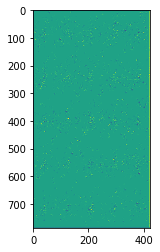

In [112]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(np.squeeze(val_preds[0], axis=2), interpolation='nearest')
plt.show()

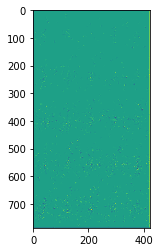

In [113]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(np.squeeze(val_preds[10], axis=2), interpolation='nearest')
plt.show()

In [114]:
np.squeeze(val_preds[10], axis=2).sum(0)

array([[-0.11777907],
       [ 0.39622667],
       [ 0.64321756],
       [ 0.92146564],
       [ 0.84280753],
       [ 0.8441577 ],
       [ 0.84463507],
       [ 0.84112513],
       [ 0.844412  ],
       [ 0.84744465],
       [ 0.84150517],
       [ 0.84039986],
       [ 0.8457235 ],
       [ 0.8442777 ],
       [ 0.84311265],
       [ 0.84322363],
       [ 0.8434591 ],
       [ 0.84516865],
       [ 0.84501386],
       [ 0.8399059 ],
       [ 0.842146  ],
       [ 0.8485378 ],
       [ 0.84374726],
       [ 0.8395302 ],
       [ 0.84541804],
       [ 0.84366524],
       [ 0.84491706],
       [ 0.84274244],
       [ 0.8425725 ],
       [ 0.84350663],
       [ 0.8449451 ],
       [ 0.8465955 ],
       [ 0.83991563],
       [ 0.8416985 ],
       [ 0.8445397 ],
       [ 0.84622616],
       [ 0.845119  ],
       [ 0.8385777 ],
       [ 0.8405636 ],
       [ 0.8496435 ],
       [ 0.84996337],
       [ 0.8329839 ],
       [ 0.84068686],
       [ 0.85047716],
       [ 0.8442317 ],
       [ 0